### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 30213022 # enter the SSID number to model as an int here, in place of xxxxxxxx
iters = 100 # enter the number of randomised search iterations here 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR

from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV

from sklearn.metrics.scorer import make_scorer
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 4.69 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(1239, 12)

time: 30 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 1 unique JPIDs traversing this segment, over the course of 1239 observations.
time: 3 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 4 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 7 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(1239, 14)

time: 22 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 2 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [11]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 30 ms


In [12]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 5 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,SchoolHoliday,Day,HourFrame
0,18,0.033325,14.5,0,Tuesday,7
1,20,0.000000,16.5,0,Tuesday,10
2,43,0.000000,17.5,0,Tuesday,12
3,41,0.000000,16.5,0,Tuesday,15
4,43,0.000000,14.0,0,Tuesday,18
5,59,0.000000,15.5,0,Tuesday,9
6,59,0.000000,14.0,0,Tuesday,17
7,39,0.000000,15.0,0,Tuesday,8
8,39,0.000000,16.5,0,Tuesday,15
9,19,0.000000,16.0,0,Tuesday,19


time: 22 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

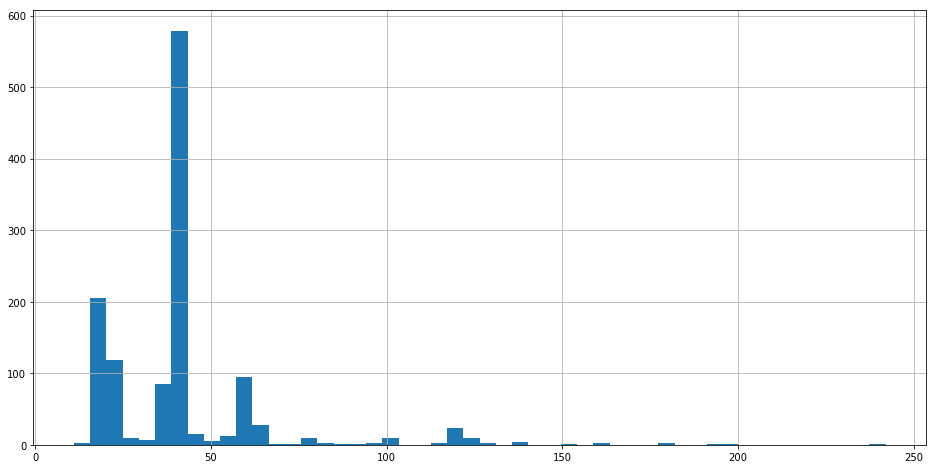

time: 253 ms


In [14]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

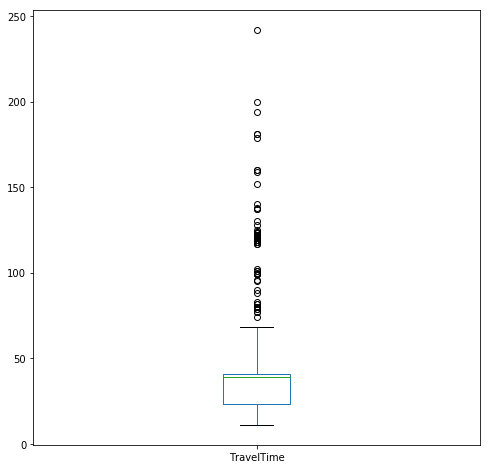

time: 114 ms


In [15]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [16]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    1239.000000
mean       41.774011
std        24.450219
min        11.000000
25%        23.000000
50%        39.000000
75%        41.000000
max       242.000000
Name: TravelTime, dtype: float64

time: 5 ms


Dropping outliers

In [17]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

16.0223390399
time: 19 ms


In [18]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

Outlier_Count = trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0]
Row_Count = Row_Count - Outlier_Count

print("There will be", Outlier_Count, "outliers dropped.")

There will be 72 outliers dropped.
time: 16 ms


In [19]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 37 ms


In [20]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    1167.000000
mean       37.432734
std        13.296412
min        17.000000
25%        22.000000
50%        39.000000
75%        41.000000
max        95.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

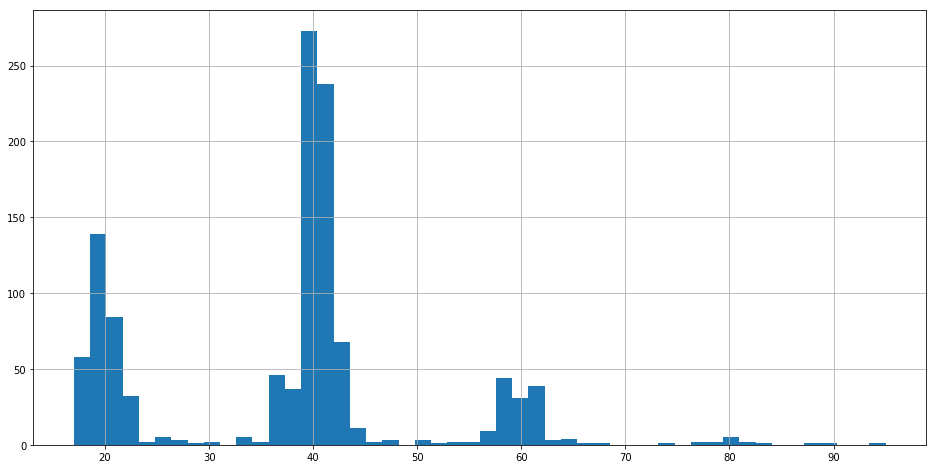

time: 210 ms


In [21]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

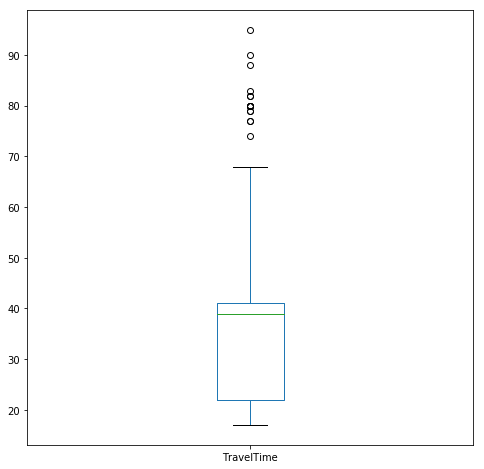

time: 115 ms


In [22]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

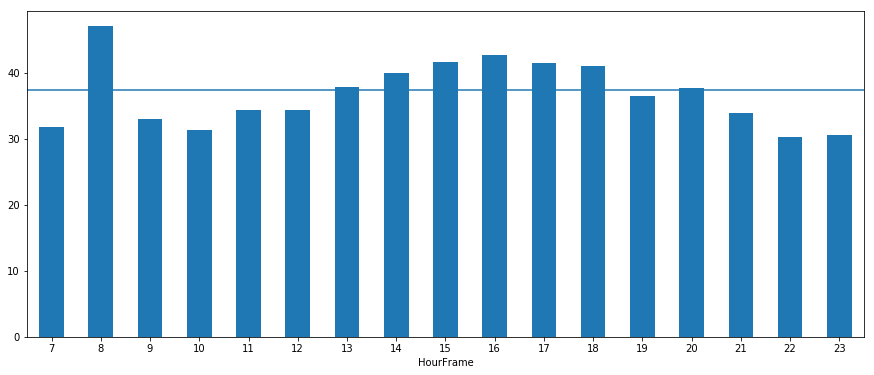

time: 172 ms


In [23]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

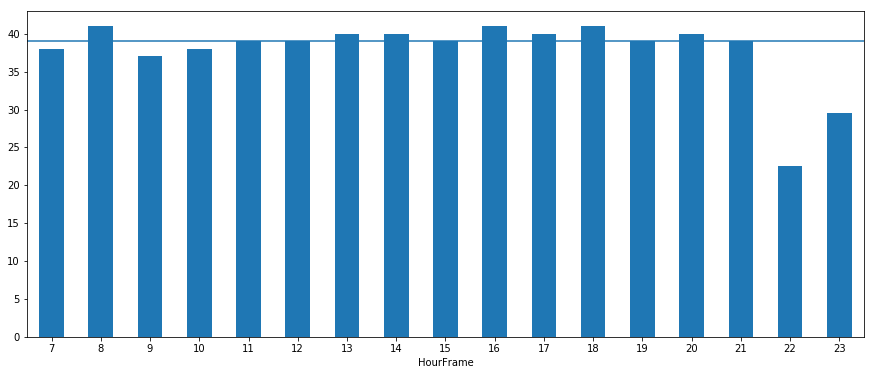

time: 184 ms


In [24]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

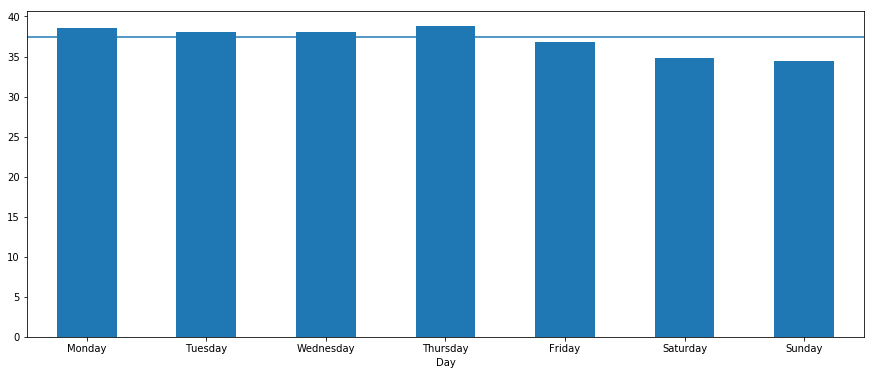

time: 157 ms


In [25]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

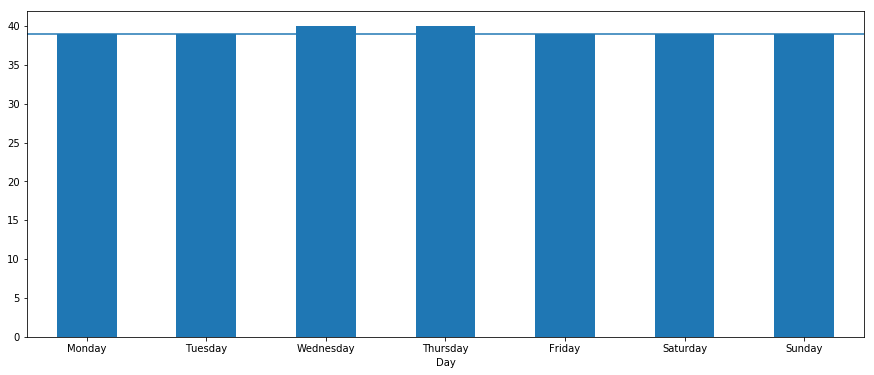

time: 187 ms


In [26]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

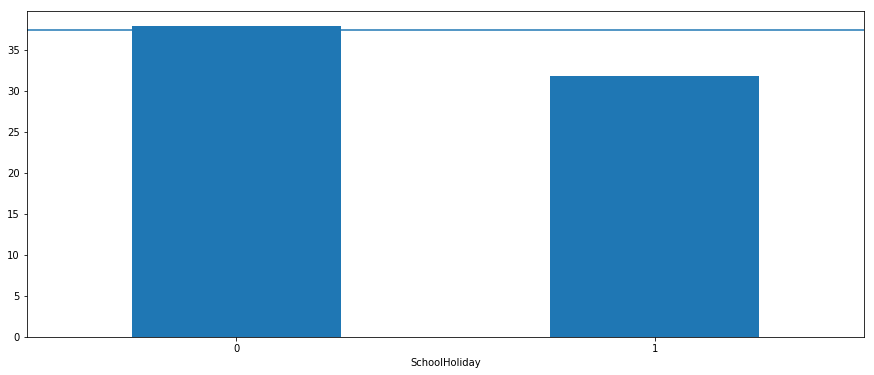

time: 129 ms


In [27]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

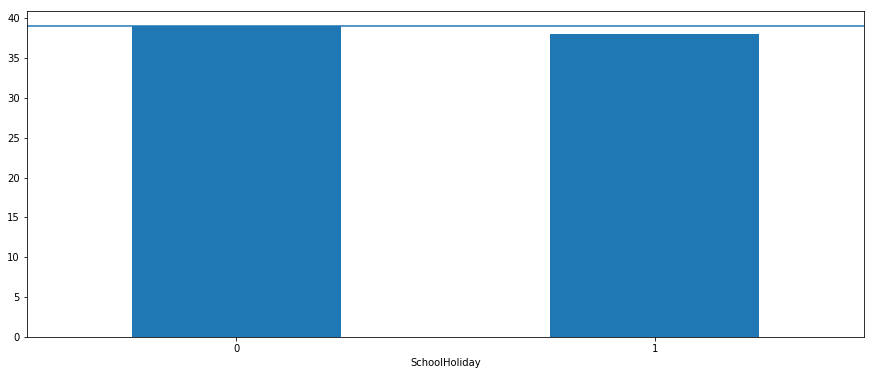

time: 134 ms


In [28]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [29]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,SchoolHoliday,HF_8,HF_9,HF_10,HF_11,HF_12,HF_13,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,95,0.000000,6.5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,90,0.000000,9.5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,88,0.000000,15.5,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,83,0.000000,9.5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,82,0.000000,5.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,82,0.000000,12.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,80,0.133301,15.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,80,0.000000,5.5,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,80,0.000000,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,80,0.133301,5.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


time: 54 ms


In [30]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'SchoolHoliday', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1e+03 µs


In [31]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 5 ms


In [32]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 5 ms


For comparison purposes, first train on Linear Regression

### 3.2a Linear Regression model (via scikit-learn) - training - default parameters

In [33]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 34 ms


In [34]:

lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)
print()
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))
print()
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.177003739944

The mean absolute error of the Linear Regression model is 9.47412204376
The mean absolute percentage error is 25.3097253573

The median absolute error of the Linear Regression model is 7.9757558022
The median absolute percentage error is 20.4506559031
time: 11 ms


### 3.2b Linear Regression model (via scikit-learn) - testing - default parameters

In [35]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)
print()
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))
print()
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.0750053098427

The mean absolute error of the Linear Regression model is 10.1185452964
The mean absolute percentage error is 27.0312754347

The median absolute error of the Linear Regression model is 8.25331074386
The median absolute percentage error is 21.1623352407
time: 10 ms


### 3.3a Gradient Boosting Regression model - training - default parameters

In [36]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 57 ms


In [37]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.330205250643
Rain 	 0.137462005257
HF_8 	 0.0671523339148
HF_10 	 0.0374812996116
HF_17 	 0.0330856582601
Day_Wednesday 	 0.0329523435117
HF_16 	 0.0325992523938
SchoolHoliday 	 0.0290542279298
Day_Monday 	 0.0289031554681
Day_Saturday 	 0.0277259351364
Day_Sunday 	 0.0276848958274
HF_22 	 0.0275693594491
HF_15 	 0.0271066654488
HF_18 	 0.0221165397935
Day_Thursday 	 0.0219717292346
Day_Tuesday 	 0.0211241637139
HF_23 	 0.0194074603881
HF_14 	 0.0178225316428
HF_20 	 0.0136448619442
HF_9 	 0.0111055130098
HF_11 	 0.0107736361646
HF_21 	 0.0104144738496
HF_19 	 0.00669226389816
HF_13 	 0.00300861227939
HF_12 	 0.00293583122995
time: 59 ms


In [38]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.330224314726

The mean absolute error of the trained Gradient Boosting Regression model is 8.37837422529
The mean absolute percentage error is 22.382480361

The median absolute error of the trained Gradient Boosting Regression model is 6.58351926485
The median absolute percentage error is 16.8808186278
time: 14 ms


### 3.3b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the tested Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the tested Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the tested Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.0495379305621

The mean absolute error of the trained Gradient Boosting Regression model is 10.1427216678
The mean absolute percentage error is 27.0958616115

The median absolute error of the trained Gradient Boosting Regression model is 7.89099542951
The median absolute percentage error is 20.2333216141
time: 9 ms


### 3.4a Gradient Boosting Regression model - training - LAD loss function 

In [68]:
gbr = GBR(loss='lad')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 72 ms


In [69]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.603126909892
HF_18 	 0.133518935761
HF_8 	 0.0542238253696
Day_Saturday 	 0.0360939111802
HF_16 	 0.0231408001435
SchoolHoliday 	 0.02235547992
HF_17 	 0.0220761346359
Day_Thursday 	 0.0218891400752
HF_12 	 0.0183899202126
Rain 	 0.0164954457154
Day_Wednesday 	 0.0119508743248
HF_9 	 0.00849027005712
Day_Sunday 	 0.00558341865495
HF_13 	 0.00530181109372
HF_21 	 0.00430895210594
Day_Monday 	 0.00409672256193
HF_19 	 0.00274473291688
HF_10 	 0.00254095660347
HF_23 	 0.00234639745046
HF_22 	 0.00132536132499
HF_20 	 0.0
Day_Tuesday 	 0.0
HF_15 	 0.0
HF_14 	 0.0
HF_11 	 0.0
time: 57 ms


In [70]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.05749930994

The mean absolute error of the trained Gradient Boosting Regression model is 8.83925910879
The mean absolute percentage error is 23.6137152732

The median absolute error of the trained Gradient Boosting Regression model is 2.82071307407
The median absolute percentage error is 7.23259762582
time: 8 ms


### 3.4b Gradient Boosting Regression model - testing - LAD loss function 

In [71]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the tested Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the tested Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the tested Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the tested Gradient Boosting Regression model is 0.0209492983651

The mean absolute error of the tested Gradient Boosting Regression model is 9.32593799271
The mean absolute percentage error is 24.9138577912

The median absolute error of the tested Gradient Boosting Regression model is 3.6
The median absolute percentage error is 9.23076923077
time: 9 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [72]:
gbr = GBR(loss='huber')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

time: 98 ms


In [73]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.31140212002
Rain 	 0.109455093309
HF_8 	 0.0753365123155
Day_Wednesday 	 0.0479387205267
HF_16 	 0.0451260520174
SchoolHoliday 	 0.0417600658756
HF_17 	 0.0384470217733
HF_15 	 0.037231681408
HF_18 	 0.035838216523
Day_Sunday 	 0.0342687800507
HF_10 	 0.0277935039002
Day_Saturday 	 0.0240326978933
HF_14 	 0.022874775793
Day_Monday 	 0.0219318980143
HF_22 	 0.0196519724392
Day_Tuesday 	 0.0180342955354
HF_23 	 0.0169017050602
Day_Thursday 	 0.0161717819464
HF_9 	 0.0148802226851
HF_21 	 0.0135931802164
HF_11 	 0.0106603274443
HF_19 	 0.0084634898304
HF_13 	 0.00731912296002
HF_12 	 0.000886762463096
HF_20 	 0.0
time: 63 ms


In [74]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.309413573011

The mean absolute error of the trained Gradient Boosting Regression model is 8.46462885513
The mean absolute percentage error is 22.6129060387

The median absolute error of the trained Gradient Boosting Regression model is 6.81936108519
The median absolute percentage error is 17.4855412441
time: 9 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [75]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the tested Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the tested Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the tested Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the tested Gradient Boosting Regression model is 0.0730989563115

The mean absolute error of the tested Gradient Boosting Regression model is 10.1176877654
The mean absolute percentage error is 27.0289845762

The median absolute error of the tested Gradient Boosting Regression model is 8.18077676382
The median absolute percentage error is 20.9763506765
time: 8 ms


## 4 Parameter tuning with RandomizedSearchCV

In [76]:
print("Note that there are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

Note that there are 1 unique JPIDs traversing this segment, over the course of 1167 observations.
time: 2 ms


In [77]:
STOP HERE - from results above, select best loss function for each of the three trainings below,

SyntaxError: invalid syntax (<ipython-input-77-df044ab76723>, line 1)

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

##### Train with Median Absolute Error as scorer

In [134]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), subsample = 0.8)

param_gbr = {'n_estimators': stats.randint(50, 250),
            'max_depth': stats.randint(3, 8),
            'min_samples_leaf': stats.randint(5, 40),
            'learning_rate': stats.uniform(0.01, 0.15)}

time: 5 ms


In [135]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=11, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC47F0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC49B0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC4B00>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC4C88>},
          pre_dispatch='2*n_jobs', random

time: 36.1 s


In [136]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.012058088506714967, 'max_depth': 3, 'min_samples_leaf': 15, 'n_estimators': 71}
time: 1 ms


In [137]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 4.42236665592
Best MdAPE found is 11.339%
time: 4 ms


In [138]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 
                                       'param_max_depth', 'param_min_samples_leaf', 'param_learning_rate', 'mean_fit_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_learning_rate,mean_fit_time
0,1,-4.434772,-4.422367,71,3,15,0.0120581,0.0652
1,2,-4.222329,-4.509017,81,7,39,0.0108168,0.1084
2,3,-5.032840,-5.270291,76,4,19,0.0156839,0.0776
3,4,-5.503113,-5.738016,60,3,39,0.0439021,0.0512
4,5,-5.765759,-6.023252,115,7,25,0.0118986,0.1548
5,6,-5.603084,-6.107573,72,3,19,0.0285651,0.0638
6,7,-6.191665,-6.459943,93,5,32,0.0220613,0.1036
7,8,-6.376450,-6.654813,85,5,37,0.0369468,0.0960
8,9,-6.204738,-6.824453,73,3,13,0.0373798,0.0682
9,10,-6.850605,-7.055008,127,6,29,0.0240891,0.1574


time: 38 ms


In [139]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0432692437345

Mean absolute error of best model on the test set is 9.59187866345
Mean absolute percentage error of best model on the test set is 24.595%

Median absolute error of best model on the test set is 4.6861817269
Median absolute percentage error of best model on the test set is 12.016%
time: 13 ms


##### Train with Mean Absolute Error as scorer

In [140]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), subsample = 0.8)

param_gbr = {'n_estimators': stats.randint(50, 250),
            'max_depth': stats.randint(3, 8),
            'min_samples_leaf': stats.randint(5, 40),
            'learning_rate': stats.uniform(0.01, 0.15)}

time: 4 ms


In [141]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=11, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC3DD8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC34A8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC3048>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FC30F0>},
          pre_dispatch='2*n_jobs', random

time: 32.6 s


In [142]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.010445011606981277, 'max_depth': 3, 'min_samples_leaf': 38, 'n_estimators': 83}
time: 2 ms


In [143]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 9.38808570559
Best MdAPE found is 24.072%
time: 2 ms


In [144]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 
                                       'param_max_depth', 'param_min_samples_leaf', 'param_learning_rate', 'mean_fit_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_learning_rate,mean_fit_time
0,1,-9.277866,-9.388086,83,3,38,0.010445,0.0724
1,2,-9.215966,-9.446033,100,5,23,0.0121646,0.1110
2,3,-9.291002,-9.451852,77,3,26,0.0142281,0.0652
3,4,-9.267527,-9.559662,104,3,21,0.0223107,0.0910
4,5,-9.234640,-9.583916,183,3,15,0.0131442,0.1762
5,6,-9.209894,-9.653549,54,4,23,0.0594672,0.0548
6,7,-9.260995,-9.677140,104,7,36,0.0174174,0.1776
7,8,-9.166663,-9.679790,70,7,26,0.0298633,0.0956
8,9,-9.418965,-9.690877,105,3,34,0.0223444,0.1008
9,10,-9.361229,-9.703465,54,3,30,0.0613972,0.0596


time: 39 ms


In [145]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0416851026817

Mean absolute error of best model on the test set is 9.61753335265
Mean absolute percentage error of best model on the test set is 24.66%

Median absolute error of best model on the test set is 4.4301857575
Median absolute percentage error of best model on the test set is 11.359%
time: 13 ms


##### Train with R-squared value as scorer

In [146]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), subsample = 0.8)

param_gbr = {'n_estimators': stats.randint(50, 250),
            'max_depth': stats.randint(3, 8),
            'min_samples_leaf': stats.randint(5, 40),
            'learning_rate': stats.uniform(0.01, 0.15)}

time: 4 ms


In [147]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=11, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FE7FD0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FE72E8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FE7400>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000022FE75C0>},
          pre_dispatch='2*n_jobs', random

time: 33.9 s


In [148]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.032180135634028731, 'max_depth': 6, 'min_samples_leaf': 24, 'n_estimators': 71}
time: 1e+03 µs


In [149]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best R-squared value found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best R-squared value found is 0.102833938328
Best MdAPE found is 0.264%
time: 3 ms


In [150]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 
                                       'param_max_depth', 'param_min_samples_leaf', 'param_learning_rate', 'mean_fit_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_learning_rate,mean_fit_time
0,1,0.184924,0.102834,71,6,24,0.0321801,0.0962
1,2,0.188250,0.102731,195,4,18,0.016103,0.2086
2,3,0.166287,0.098594,109,4,17,0.0200224,0.1260
3,4,0.215637,0.096933,173,6,21,0.0187696,0.2224
4,5,0.207564,0.096515,128,7,21,0.0194568,0.1790
5,6,0.154302,0.095681,110,3,14,0.0212158,0.1120
6,7,0.218130,0.093648,131,5,16,0.0260297,0.1712
7,8,0.215814,0.089561,61,4,27,0.108274,0.0674
8,9,0.218415,0.084973,51,4,27,0.134285,0.0524
9,10,0.136672,0.084967,99,3,33,0.0305482,0.0836


time: 36 ms


In [151]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0860518267977

Mean absolute error of best model on the test set is 9.88326564401
Mean absolute percentage error of best model on the test set is 25.342%

Median absolute error of best model on the test set is 7.00639912001
Median absolute percentage error of best model on the test set is 17.965%
time: 13 ms


The 'huber' loss function seems minimally better than other pair, with slightly less variation between testing and training, and less deviation between testing and training scores.

### 5.5a Gradient Boosting Regression model - training - HUBER loss function 

In [176]:
gbr = GBR(loss='huber', learning_rate=0.02, n_estimators=300, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 360 ms


In [177]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.246173973853
Rain 	 0.11244697615
HF_8 	 0.0908121282795
SchoolHoliday 	 0.052042085145
HF_17 	 0.0490744972127
HF_16 	 0.0439833625549
HF_18 	 0.0385479318365
HF_15 	 0.0382997734782
HF_10 	 0.0348621021941
Day_Sunday 	 0.0298889214629
Day_Thursday 	 0.0296805915454
HF_14 	 0.0288507254143
Day_Saturday 	 0.028745326519
HF_22 	 0.0276864211538
HF_23 	 0.0257889650591
HF_9 	 0.0232302918553
Day_Tuesday 	 0.0220457564552
Day_Wednesday 	 0.0215558969947
Day_Monday 	 0.0164620739901
HF_21 	 0.012647215511
HF_11 	 0.00816174162475
HF_19 	 0.00774339132619
HF_13 	 0.00456421142356
HF_12 	 0.00440529094463
HF_20 	 0.00230034801532
time: 160 ms


In [178]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.279859970515

The mean absolute error of the trained Gradient Boosting Regression model is 8.68616748428
The mean absolute percentage error is 23.2047373275

The median absolute error of the trained Gradient Boosting Regression model is 7.02164369842
The median absolute percentage error is 18.0042146113
time: 12 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [179]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the tested Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the tested Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the tested Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the tested Gradient Boosting Regression model is 0.0788944178299

The mean absolute error of the tested Gradient Boosting Regression model is 10.0638522696
The mean absolute percentage error is 26.8851652746

The median absolute error of the tested Gradient Boosting Regression model is 8.06361635271
The median absolute percentage error is 20.6759393659
time: 11 ms
